In [0]:
# import library packages
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [0]:
# download dataset
train_data = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# load dataset into DataLoader with defined batch size
BATCH_SIZE = 64
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

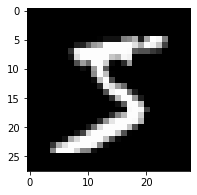

In [0]:
# print a sample of dataset
dataiter = iter(train_loader)
img, _ = dataiter.next()
img = img.numpy()
img = np.squeeze(img[0])

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(img.reshape(28,28), cmap='gray')
plt.show()

In [0]:
# choose device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Encoder** $Q(z | X)$

In [0]:
class Encoder(nn.Module):
  """ This is the Encoder, part of VAE """

  def __init__(self, input_dim, hidden_dim, z_dim):
    """ Initialization

    Parameters:
    ----------
    input_dim: int
          the size of the input (in case of MNIST 28*28)
    hidden_dim: int
          the size of the hidden layer
    z_dim: int
          latent dimension
    """
    super().__init__()

    self.linear = nn.Linear(input_dim, hidden_dim)
    self.mu = nn.Linear(hidden_dim, z_dim)
    self.var = nn.Linear(hidden_dim, z_dim)

  def forward(self, x):
    """ forward pass

    Parameters:
    ----------
    x: Tensor
          samples (in batch) from MNIST dataset

    Return:
    ----------
    z_mu: Tensor
          mean of proposal distribution
    z_var: Tensor
          log variance of proposal distribution
    """
    h = F.relu(self.linear(x))
    z_mu = self.mu(h)
    z_var = self.var(h)

    return z_mu, z_var

**Decoder** $P(X | z)$

In [0]:
class Decoder(nn.Module):
  '''
  This is the Decoder, part of VAE
  '''
  def __init__(self, z_dim, hidden_dim, output_dim):
    """ Initialization

    Parameters:
    ----------
    z_dim: int
          latent dimension
    hidden_dim: int
          the size of the hidden layer
    input_dim: int
          the size of the output (in case of MNIST 28*28)
    """
    super().__init__()

    self.linear = nn.Linear(z_dim, hidden_dim)
    self.out = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    """ forward pass

    Parameters:
    ----------
    x: Tensor
          generated sample from proposal distribution

    Return:
    ----------
    pred: Tensor
          decoded output (reconstruction sample)
    """
    h = F.relu(self.linear(x))
    pred = torch.sigmoid(self.out(h))

    return pred

Combine encoder and decoder into VAE class

In [0]:
class VAE(nn.Module):
  '''
  This is the VAE, which takes encoder and decoder
  '''
  def __init__(self, enc, dec):
    """ Initialization

    Parameters:
    ----------
    enc: class
          encoder object
    dec: class
          decoder object
    """
    super().__init__()
    
    self.enc = enc
    self.dec = dec

  def forward(self, x):
    """ forward pass

    Parameters:
    ----------
    x: Tensor
          samples (in batch) from MNIST dataset

    Return:
    ----------
    pred: Tensor
          decoded output (reconstruction sample)
    z_mu: Tensor
          mean of proposal distribution
    z_var: Tensor
          log variance of proposal distribution
    """

    # Encode
    z_mu, z_var = self.enc(x)

    # Reparameterization
    std = torch.exp(z_var/2)
    eps = torch.randn_like(std)
    z_sample = eps.mul(std).add(z_mu)

    # Decode
    pred = self.dec(z_sample)

    return pred, z_mu, z_var

In [0]:
# hyper-parameters setting
N_EPOCHS = 10
INPUT_DIM = 28*28
HIDDEN_DIM = 256
LATENT_DIM = 20
lr = 1e-3

In [0]:
# encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)
# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)
# vae
model = VAE(encoder, decoder).to(device)
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [0]:
# Training
def train():

  # set to train mode
  model.train()
  train_loss = 0

  for batch_idx, (x, _) in enumerate(train_loader):
    
    # reshape data tensor and send it to current device
    x = x.view(-1, 28*28).to(device)

    # update the gradient to zero
    optimizer.zero_grad()

    # forward pass
    x_sample, z_mu, z_var = model(x)

    # reconstruction loss
    recon_loss = F.binary_cross_entropy(x_sample, x, reduction='sum')

    # kl divergence loss
    kl_loss = -0.5*torch.sum(1.0 + z_var - z_mu**2 - torch.exp(z_var))
    
    # total_loss
    # loss = 0
    loss = recon_loss + kl_loss

    # backward pass
    loss.backward()
    train_loss += loss.item()
    
    # update the weights
    optimizer.step()

  return train_loss

In [0]:
# Testing
def test():

  # set to test mode
  model.eval()
  test_loss = 0

  for i, (x, _) in enumerate(test_loader):
    
    # reshape data tensor and send it to current device
    x = x.view(-1, 28*28).to(device)

    # forward pass
    x_sample, z_mu, z_var = model(x)

    # reconstruction loss
    recon_loss = F.binary_cross_entropy(x_sample, x, reduction='sum')
    
    # kl divergence loss
    kl_loss = -0.5*torch.sum(1.0 + z_var - z_mu**2 - torch.exp(z_var))
    
    # total loss on test set
    loss = recon_loss + kl_loss

    # accumulated loss on batchs
    test_loss += loss.item()
  
  return test_loss

In [0]:
# Train model on several epochs
for i in range(N_EPOCHS):

  train_loss = train()
  test_loss = test()

  train_loss = train_loss/len(train_data)
  test_loss = test_loss/len(test_data)

  print('Epoch {}: Train Loss: {:.4f}, Test Loss: {:.4f}'.format(i, train_loss, test_loss))

Epoch 0: Train Loss: 159.0762, Test Loss: 129.2884
Epoch 1: Train Loss: 121.6889, Test Loss: 118.9145
Epoch 2: Train Loss: 115.0340, Test Loss: 114.1091
Epoch 3: Train Loss: 112.1122, Test Loss: 112.2739
Epoch 4: Train Loss: 110.5277, Test Loss: 110.8353
Epoch 5: Train Loss: 109.4654, Test Loss: 109.7162
Epoch 6: Train Loss: 108.6603, Test Loss: 109.0945
Epoch 7: Train Loss: 108.1077, Test Loss: 108.6172
Epoch 8: Train Loss: 107.6396, Test Loss: 108.2995
Epoch 9: Train Loss: 107.2796, Test Loss: 107.9326


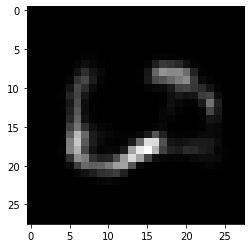

In [0]:
# Sample from the distribution and generate the image
z = torch.randn(1, LATENT_DIM).to(device)

reconstructed_img = model.dec(z)
img = torch.Tensor.cpu(reconstructed_img.view(28,28).data).numpy()

plt.imshow(img, cmap='gray')
plt.show()